In [23]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Step 1: Preprocessing
def preprocess_dataset(df, label_cols, drop_cols=None):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=label_cols + drop_cols)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler

# Step 2: Tensor conversion
def create_dataloaders(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long),
        torch.tensor(y_test, dtype=torch.long),
    )

# Step 3: MLP Definition
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, num_classes=6):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )
    def forward(self, x):
        return self.model(x)

# Step 4: Training
def train_mlp_model(X_train, y_train, input_dim, num_classes, epochs=30, lr=0.001):
    model = CowHealthMLP(input_dim=input_dim, num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")
    return model

# def plot_confusion_matrix(y_true, y_pred, label_names):
   
#     cm = confusion_matrix(y_true, y_pred, labels=list(range(len(label_names))))

#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.show()
# Step 5: Evaluation

def evaluate_model(model, X_test, y_test, label_names):
    model.eval()
    with torch.no_grad():
        preds = model(X_test).argmax(dim=1)
        print("\n📊 Classification Report:")
        print(classification_report(y_test, preds, target_names=label_names))
        # plot_confusion_matrix(y_test.numpy(), preds.numpy(), label_names)
        cm = confusion_matrix(y_test, preds)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Plot with counts and normalized percentages
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_normalized, annot=False, cmap='Blues', cbar=True)


        for i in range(cm.shape[0]):
             for j in range(cm.shape[1]):
                 plt.text(j+0.5, i+0.5, f"{cm[i, j]}\n({cm_normalized[i,j]*100:.3f}%)",
                    ha='center', va='center',
                    fontsize=10,
                    color='white' if cm_normalized[i,j] > 0.5 else 'black')

        # Tick labels
        plt.xticks(np.arange(len(label_names)) + 0.5, label_names, rotation=45, ha='right')
        plt.yticks(np.arange(len(label_names)) + 0.5, label_names, rotation=0)
        plt.title('Confusion Matrix (Counts and Normalized Percentages by Row)', fontsize=14, weight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.tight_layout()
        plt.show()
        

# Step 6: Full pipeline
def run_pipeline(df, label_cols, drop_cols=None):
    print("🔄 Running pipeline...")
    X, y, scaler = preprocess_dataset(df, label_cols=label_cols, drop_cols=drop_cols)
    X_train, X_test, y_train, y_test = create_dataloaders(X, y)
    model = train_mlp_model(X_train, y_train, input_dim=X.shape[1], num_classes=len(label_cols))
    evaluate_model(model, X_test, y_test, label_names=label_cols)
    return model, scaler


🔄 Running pipeline...
Epoch 5/30 - Loss: 1.8599
Epoch 10/30 - Loss: 1.7219
Epoch 15/30 - Loss: 1.5739
Epoch 20/30 - Loss: 1.4065
Epoch 25/30 - Loss: 1.2197
Epoch 30/30 - Loss: 1.0231

📊 Classification Report:
               precision    recall  f1-score   support

      oestrus       0.00      0.00      0.00       701
      calving       0.00      0.00      0.00       159
     lameness       0.00      0.00      0.00        85
     mastitis       0.00      0.00      0.00       107
other_disease       0.00      0.00      0.00       180
           OK       0.93      1.00      0.97     17640

     accuracy                           0.93     18872
    macro avg       0.16      0.17      0.16     18872
 weighted avg       0.87      0.93      0.90     18872



c:\Users\lamia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lamia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


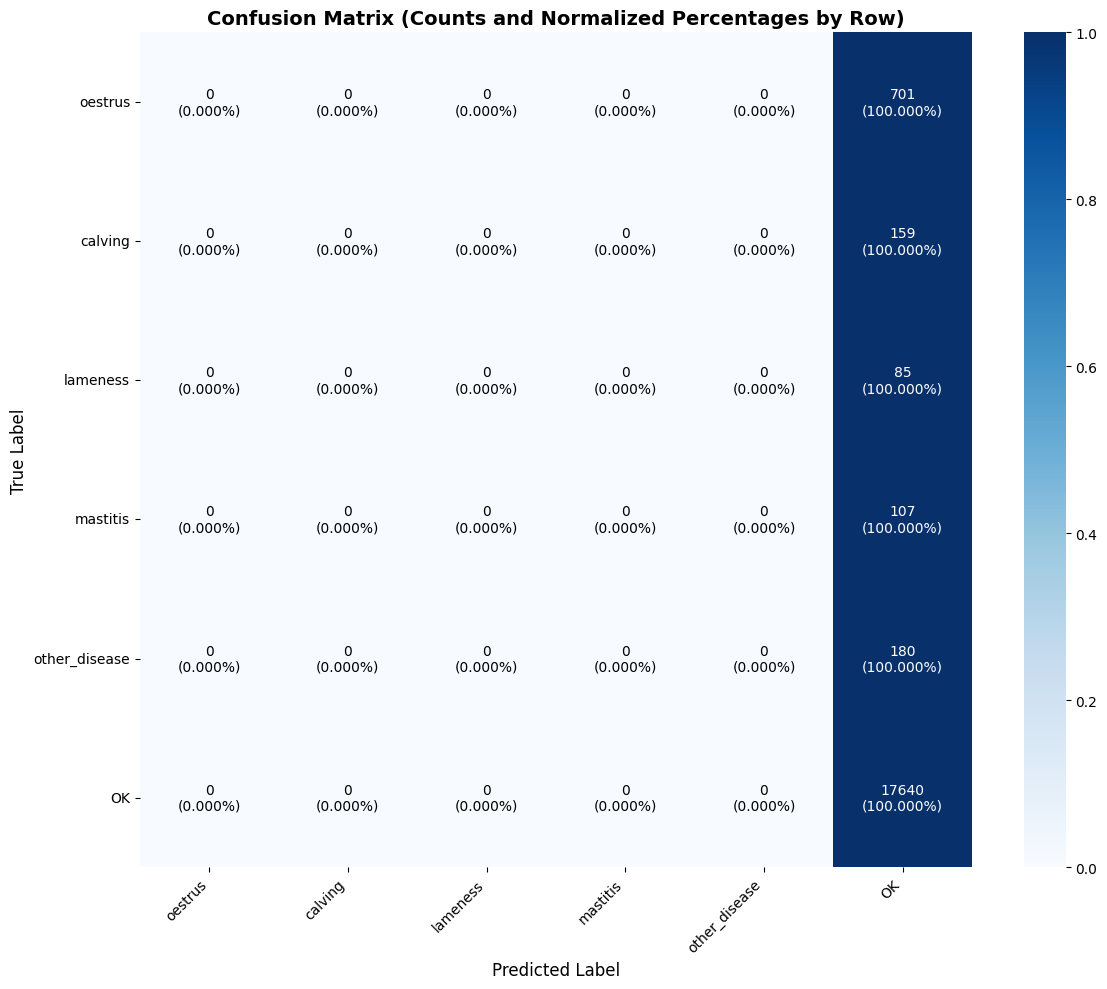

In [24]:
df = pd.read_csv(r"C:/Users/lamia/Downloads/final_selected_dataset1_trainval.csv")
label_columns = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
drop_columns = ['cow', 'start_time', 'end_time']

model, scaler = run_pipeline(df, label_cols=label_columns, drop_cols=drop_columns)


**Improvements (fine tuning)**

In [25]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
def preprocess_dataset(df, label_cols, drop_cols=None):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=label_cols + drop_cols)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler

# Class weights for imbalance
def compute_class_weights(y, num_classes):
    weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=y)
    return torch.tensor(weights, dtype=torch.float32)

# Train-test split and tensor conversion
def create_dataloaders(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return (
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(X_test, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.long),
        torch.tensor(y_test, dtype=torch.long),
    )

# Improved MLP model
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64, num_classes=6):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Model training
def train_mlp_model(X_train, y_train, input_dim, num_classes, epochs=30, lr=0.001):
    model = CowHealthMLP(input_dim=input_dim, num_classes=num_classes)
    class_weights = compute_class_weights(y_train.numpy(), num_classes)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")
    return model

# Evaluation
def evaluate_model(model, X_test, y_test, label_names):
    model.eval()
    with torch.no_grad():
        preds = model(X_test).argmax(dim=1)
        print("\n📊 Classification Report:")
        print(classification_report(y_test, preds, target_names=label_names))
        # plot_confusion_matrix(y_test.numpy(), preds.numpy(), label_names)
        cm = confusion_matrix(y_test, preds)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Plot with counts and normalized percentages
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_normalized, annot=False, cmap='Blues', cbar=True)


        for i in range(cm.shape[0]):
             for j in range(cm.shape[1]):
                 plt.text(j+0.5, i+0.5, f"{cm[i, j]}\n({cm_normalized[i,j]*100:.3f}%)",
                    ha='center', va='center',
                    fontsize=10,
                    color='white' if cm_normalized[i,j] > 0.5 else 'black')

        # Tick labels
        plt.xticks(np.arange(len(label_names)) + 0.5, label_names, rotation=45, ha='right')
        plt.yticks(np.arange(len(label_names)) + 0.5, label_names, rotation=0)
        plt.title('Confusion Matrix (Counts and Normalized Percentages by Row)', fontsize=14, weight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.tight_layout()
        plt.show()

# Full pipeline function
def run_pipeline(df, label_cols, drop_cols=None):
    print("🔄 Running fine-tuned MLP pipeline without SMOTE...")
    X, y, scaler = preprocess_dataset(df, label_cols=label_cols, drop_cols=drop_cols)
    X_train, X_test, y_train, y_test = create_dataloaders(X, y)
    model = train_mlp_model(X_train, y_train, input_dim=X.shape[1], num_classes=len(label_cols))
    evaluate_model(model, X_test, y_test, label_names=label_cols)
    return model, scaler


🔄 Running fine-tuned MLP pipeline without SMOTE...
Epoch 5/30 - Loss: 1.7386
Epoch 10/30 - Loss: 1.6298
Epoch 15/30 - Loss: 1.5834
Epoch 20/30 - Loss: 1.5319
Epoch 25/30 - Loss: 1.4926
Epoch 30/30 - Loss: 1.4710

📊 Classification Report:
               precision    recall  f1-score   support

      oestrus       0.06      0.29      0.10       701
      calving       0.05      0.77      0.09       159
     lameness       0.02      0.54      0.03        85
     mastitis       0.02      0.51      0.03       107
other_disease       0.05      0.44      0.08       180
           OK       0.95      0.26      0.40     17640

     accuracy                           0.27     18872
    macro avg       0.19      0.47      0.12     18872
 weighted avg       0.89      0.27      0.38     18872



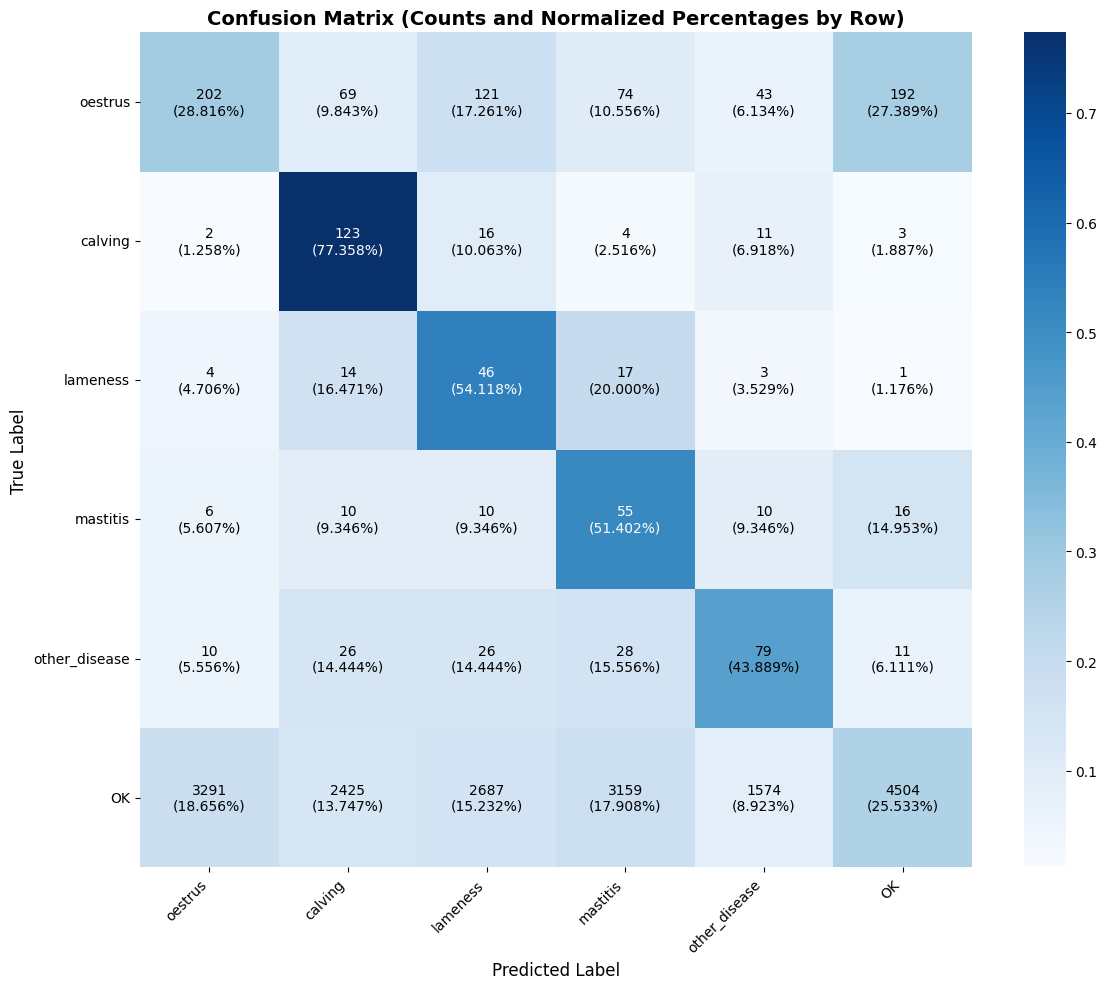

In [26]:
df = pd.read_csv(r"C:/Users/lamia/Downloads/final_selected_dataset1_trainval.csv")
label_columns = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
drop_columns = ['cow', 'start_time', 'end_time']  

model, scaler = run_pipeline(df, label_cols=label_columns, drop_cols=drop_columns)
